In [98]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from datetime import datetime

Using device: cuda

--- 1. Data Loading and Preprocessing ---
X_train shape: torch.Size([2768, 60, 1]), y_train shape: torch.Size([2768, 1])
X_test shape (initial for context): torch.Size([120, 60, 1]), y_test shape (initial for context): torch.Size([120, 1])
First training date in resampled data: 2017-06-04
Last training date in resampled data: 2024-12-31

--- 2. Transformer Model Definition ---

--- 3. Training the Model ---
Epoch 10/200, Loss: 0.156778
Epoch 20/200, Loss: 0.099309
Epoch 30/200, Loss: 0.085944
Epoch 40/200, Loss: 0.083246
Epoch 50/200, Loss: 0.079278
Epoch 60/200, Loss: 0.078787
Epoch 70/200, Loss: 0.077636
Epoch 80/200, Loss: 0.076675
Epoch 90/200, Loss: 0.076480
Epoch 100/200, Loss: 0.076575
Epoch 110/200, Loss: 0.075608
Epoch 120/200, Loss: 0.075632
Epoch 130/200, Loss: 0.074308
Epoch 140/200, Loss: 0.073884
Epoch 150/200, Loss: 0.074359
Epoch 160/200, Loss: 0.074547
Epoch 170/200, Loss: 0.073703
Epoch 180/200, Loss: 0.071871
Epoch 190/200, Loss: 0.073526
Epoch 20

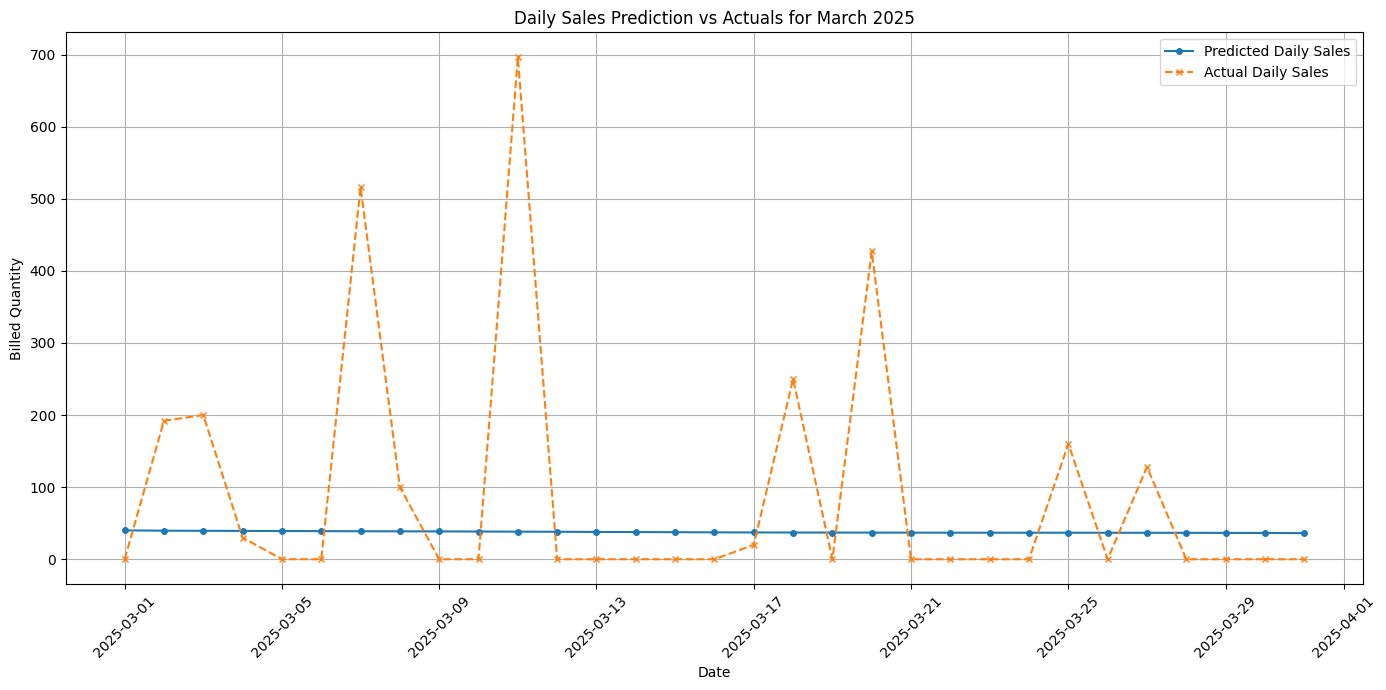

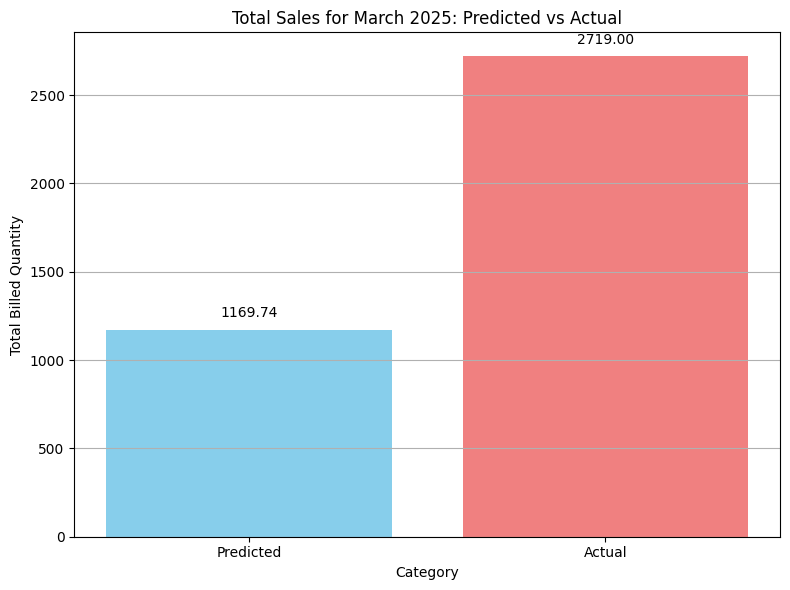

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

In [99]:
# --- Configuration ---
DATA_FILE = 'BILASPUR_5.xlsx'
SHEET_NAME = 'Sheet1'
SEQUENCE_LENGTH = 60 # Number of past days to consider for prediction (tuned for a year trend)
TRAIN_END_YEAR = 2024 # Use data up to the end of 2024 for training
PREDICT_YEAR = 2025
PREDICT_MONTH = 3 # March

# Transformer Model Hyperparameters
D_MODEL = 128         # Dimension of the embedding and transformer layers
NHEAD = 8             # Number of attention heads
NUM_ENCODER_LAYERS = 3 # Number of transformer encoder layers
DIM_FEEDFORWARD = 256 # Dimension of the feedforward network model
DROPOUT = 0.1
LEARNING_RATE = 0.0005
EPOCHS = 200          # Number of training epochs

# --- Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- 1. Data Loading and Preprocessing ---
print("\n--- 1. Data Loading and Preprocessing ---")
try:
    df = pd.read_excel(DATA_FILE, sheet_name=SHEET_NAME)
except FileNotFoundError:
    print(f"Error: '{DATA_FILE}' not found. Please make sure the file is in the correct directory.")
    exit()
except Exception as e:
    print(f"Error loading Excel file: {e}")
    exit()

# Convert 'Billing Date' to datetime objects, handling potential mixed formats
# Use infer_datetime_format=True for robustness
df['Billing Date'] = pd.to_datetime(df['Billing Date'], errors='coerce', infer_datetime_format=True)

# Drop rows where 'Billing Date' conversion failed (became NaT)
df.dropna(subset=['Billing Date'], inplace=True)

# Ensure 'Billed Quantity' is numeric, fill any non-numeric with 0
df['Billed Quantity'] = pd.to_numeric(df['Billed Quantity'], errors='coerce').fillna(0)

# Aggregate 'Billed Quantity' by 'Billing Date' to handle multiple entries per day
df_daily_sales = df.groupby('Billing Date')['Billed Quantity'].sum().reset_index()

# Set 'Billing Date' as index and sort
df_daily_sales.set_index('Billing Date', inplace=True)
df_daily_sales.sort_index(inplace=True)

# Determine the full date range for reindexing
min_date_data = df_daily_sales.index.min()
max_date_data = df_daily_sales.index.max()

# Ensure we cover the full range from min data date up to April 2025
target_end_date_for_range = pd.to_datetime(f'2025-04-30')
full_date_range_start = min_date_data
full_date_range_end = max(max_date_data, target_end_date_for_range)

# Create a complete date range and reindex to fill missing days with 0 sales
full_date_range = pd.date_range(start=full_date_range_start, end=full_date_range_end, freq='D')
df_resampled = df_daily_sales.reindex(full_date_range, fill_value=0)

# Extract only 'Billed Quantity' for the model
sales_data = df_resampled['Billed Quantity'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
sales_data_normalized = scaler.fit_transform(sales_data)

# Create sequences for the Transformer model
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X, y = create_sequences(sales_data_normalized, SEQUENCE_LENGTH)

# Convert to PyTorch tensors
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

# Split data into training and testing
# Training data: up to the end of TRAIN_END_YEAR
train_end_date = pd.to_datetime(f'{TRAIN_END_YEAR}-12-31')

# --- WORKAROUND FOR DatetimeIndex.get_loc() WITHOUT 'method' ---
# Find the index of the last date in df_resampled that is <= train_end_date
valid_training_dates = df_resampled.index[df_resampled.index <= train_end_date]
if not valid_training_dates.empty:
    train_idx_end_resampled = df_resampled.index.get_loc(valid_training_dates[-1])
else:
    print(f"Warning: No training data found at or before {train_end_date}. Training will use data up to the last available date before prediction period.")
    train_idx_end_resampled = len(df_resampled) - 1 # Fallback to end of data if no valid dates

# Calculate the split point for X and y tensors based on the training end date
train_split_point = train_idx_end_resampled - SEQUENCE_LENGTH + 1

if train_split_point <= 0: # Ensure we have at least one sequence for training
    print(f"\nError: Not enough data for training with sequence_length={SEQUENCE_LENGTH} ending at {TRAIN_END_YEAR}.")
    print("Please reduce SEQUENCE_LENGTH or extend your dataset's historical range.")
    exit()
elif train_split_point > len(X): # This can happen if df_resampled ended earlier than anticipated
     print(f"\nError: `train_split_point` ({train_split_point}) exceeds available sequences ({len(X)}).")
     print("Check your data range and `TRAIN_END_YEAR`.")
     exit()

X_train = X[:train_split_point]
y_train = y[:train_split_point]

# X_test and y_test are used for initial prediction setup, but main prediction is iterative
# We'll use the last sequence of X_train to start the iterative prediction for 2025.
X_test = X[train_split_point:]
y_test = y[train_split_point:] # These would be actual values for 2025, but we'll extract directly later

# Move tensors to CUDA
X_train = X_train.to(device)
y_train = y_train.to(device)
# X_test and y_test might be empty if all data is training, so only move if not empty
if X_test.numel() > 0:
    X_test = X_test.to(device)
if y_test.numel() > 0:
    y_test = y_test.to(device)


print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape (initial for context): {X_test.shape}, y_test shape (initial for context): {y_test.shape}")
print(f"First training date in resampled data: {df_resampled.index[SEQUENCE_LENGTH].strftime('%Y-%m-%d')}")
print(f"Last training date in resampled data: {df_resampled.index[train_idx_end_resampled].strftime('%Y-%m-%d')}")


# --- 2. Transformer Model Definition ---
print("\n--- 2. Transformer Model Definition ---")

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, d_model)
        return x + self.pe[:, :x.size(1)] # Add positional encoding to each batch item

class SalesTransformer(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_encoder_layers, dim_feedforward, output_size, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        # Linear layer to project input_size (1 for Billed Quantity) to d_model
        self.embedding = nn.Linear(input_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_encoder_layers)

        # Output layer: maps the transformer output for the last token to the predicted sales
        self.fc_out = nn.Linear(d_model, output_size)

    def forward(self, src):
        # src shape: (batch_size, sequence_length, input_size)
        src = self.embedding(src) * math.sqrt(self.d_model) # Apply embedding and scale
        src = self.positional_encoding(src) # Add positional encoding

        # Transformer encoder expects (batch_size, sequence_length, d_model) with batch_first=True
        output = self.transformer_encoder(src)

        # We take the output of the last time step for prediction
        predictions = self.fc_out(output[:, -1, :])
        return predictions

model = SalesTransformer(input_size=1, d_model=D_MODEL, nhead=NHEAD,
                         num_encoder_layers=NUM_ENCODER_LAYERS,
                         dim_feedforward=DIM_FEEDFORWARD, output_size=1, dropout=DROPOUT)
model.to(device)

# --- 3. Training the Model ---
print("\n--- 3. Training the Model ---")
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(1, EPOCHS + 1):
    model.train()
    optimizer.zero_grad()

    y_pred = model(X_train)
    loss = loss_function(y_pred, y_train)

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0 or epoch == EPOCHS:
        print(f'Epoch {epoch}/{EPOCHS}, Loss: {loss.item():.6f}')

print("Training complete.")

# --- 4. Predicting March 2025 Sales ---
print("\n--- 4. Predicting March 2025 Sales ---")
model.eval() # Set model to evaluation mode
predicted_sales_normalized = []

with torch.no_grad():
    # Start with the last sequence from the training data to make the first prediction for Jan 1, 2025
    # Ensure X_train is not empty before attempting to access its last element
    if X_train.numel() == 0:
        print("Error: X_train is empty. Cannot start prediction.")
        exit()
    current_prediction_sequence = X_train[-1:].clone().to(device) # .clone() to avoid modifying original

    # Define the prediction period (January 1, 2025 to March 31, 2025)
    prediction_start_date = pd.to_datetime(f'{PREDICT_YEAR}-01-01')
    prediction_end_date = pd.to_datetime(f'{PREDICT_YEAR}-{PREDICT_MONTH}-31') # End of March 2025

    # If the end date is earlier than the start date, adjust
    if prediction_end_date < prediction_start_date:
        prediction_end_date = prediction_start_date # Predict at least one day

    prediction_dates = pd.date_range(start=prediction_start_date, end=prediction_end_date, freq='D')
    num_prediction_steps = len(prediction_dates)

    for i in range(num_prediction_steps):
        prediction = model(current_prediction_sequence)
        predicted_sales_normalized.append(prediction.item())

        # Update the sequence for the next prediction
        next_input_value = prediction.view(1, 1, 1) # Reshape to (batch_size=1, seq_len=1, features=1)
        current_prediction_sequence = torch.cat((current_prediction_sequence[:, 1:, :], next_input_value), dim=1)

# Inverse transform the normalized predictions
predicted_sales_full_period = scaler.inverse_transform(np.array(predicted_sales_normalized).reshape(-1, 1)).flatten()

# Create a DataFrame for predictions for the entire period
predicted_df_full = pd.DataFrame({
    'Date': prediction_dates,
    'Predicted_Quantity': predicted_sales_full_period
})

# Filter predictions specifically for March 2025
predicted_march_2025_df = predicted_df_full[
    (predicted_df_full['Date'].dt.year == PREDICT_YEAR) &
    (predicted_df_full['Date'].dt.month == PREDICT_MONTH)
]

# Get actual sales for March 2025 from the df_resampled
actual_march_2025_df = df_resampled[
    (df_resampled.index.year == PREDICT_YEAR) &
    (df_resampled.index.month == PREDICT_MONTH)
].copy() # .copy() to avoid SettingWithCopyWarning

actual_march_2025_df.rename(columns={'Billed Quantity': 'Actual_Quantity'}, inplace=True)


# Align predicted and actual sales for March 2025 by date
comparison_df = pd.merge(
    predicted_march_2025_df,
    actual_march_2025_df[['Actual_Quantity']],
    left_on='Date',
    right_index=True,
    how='left'
)
# Fill any missing actuals (e.g., if pred_df had a date not in original actuals) with 0 for safety
comparison_df['Actual_Quantity'] = comparison_df['Actual_Quantity'].fillna(0)


# Calculate monthly totals for comparison
predicted_march_total = comparison_df['Predicted_Quantity'].sum()
actual_march_total = comparison_df['Actual_Quantity'].sum()

print(f"\n--- Sales Prediction for {datetime(PREDICT_YEAR, PREDICT_MONTH, 1).strftime('%B %Y')} ---")
print(f"Predicted Total Sales for {datetime(PREDICT_YEAR, PREDICT_MONTH, 1).strftime('%B %Y')}: {predicted_march_total:.2f}")
print(f"Actual Total Sales for {datetime(PREDICT_YEAR, PREDICT_MONTH, 1).strftime('%B %Y')}: {actual_march_total:.2f}")

# Calculate Error
abs_error = abs(predicted_march_total - actual_march_total)
percentage_error = (abs_error / actual_march_total) * 100 if actual_march_total != 0 else float('inf')
print(f"Absolute Error: {abs_error:.2f}")
print(f"Percentage Error: {percentage_error:.2f}%")


# --- 5. Visualization (March 2025 Daily and Monthly Comparison) ---
print("\n--- 5. Visualization ---")

# Daily Comparison Plot for March 2025
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Date'], comparison_df['Predicted_Quantity'], label='Predicted Daily Sales', marker='o', markersize=4, linestyle='-')
plt.plot(comparison_df['Date'], comparison_df['Actual_Quantity'], label='Actual Daily Sales', marker='x', markersize=4, linestyle='--')
plt.title(f'Daily Sales Prediction vs Actuals for {datetime(PREDICT_YEAR, PREDICT_MONTH, 1).strftime('%B %Y')}')
plt.xlabel('Date')
plt.ylabel('Billed Quantity')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Monthly Comparison Plot (just for March 2025 totals)
labels = ['Predicted', 'Actual']
values = [predicted_march_total, actual_march_total]

plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=['skyblue', 'lightcoral'])
plt.title(f'Total Sales for {datetime(PREDICT_YEAR, PREDICT_MONTH, 1).strftime('%B %Y')}: Predicted vs Actual')
plt.xlabel('Category')
plt.ylabel('Total Billed Quantity')
plt.grid(axis='y')
for i, value in enumerate(values):
    plt.text(i, value + (max(values) * 0.02), f'{value:.2f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Plot full 2025 prediction vs actuals (up to April 2025 for context)
# Get actual data for 2025 (up to April)
actual_2025_df = df_resampled[(df_resampled.index.year == 2025) & (df_resampled.index.month <= 4)].copy()
actual_2025_monthly = actual_2025_df.resample('M')['Billed Quantity'].sum()

# Get predicted data for 2025 (up to April, from the full prediction range)
predicted_2025_df_full = predicted_df_full[predicted_df_full['Date'].dt.year == 2025].copy()
predicted_2025_monthly = predicted_2025_df_full.resample('M')['Predicted_Quantity'].sum()

# Align the monthly data for plotting
combined_2025_monthly = pd.DataFrame({
    'Actual Sales': actual_2025_monthly,
    'Predicted Sales': predicted_2025_monthly
}).fillna(0) # Fill NaN with 0 where one series might not have data

plt.figure(figsize=(12, 6))
plt.plot(combined_2025_monthly.index.strftime('%Y-%b'), combined_2025_monthly['Predicted Sales'],
         label='Predicted Monthly Sales (2025)', marker='o')
plt.plot(combined_2025_monthly.index.strftime('%Y-%b'), combined_2025_monthly['Actual Sales'],
         label='Actual Monthly Sales (2025)', marker='x')
plt.title(f'Monthly Sales: Prediction vs Actuals (2025)')
plt.xlabel('Month')
plt.ylabel('Billed Quantity')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()